In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bean-leaf-lesions-classification/val.csv
/kaggle/input/bean-leaf-lesions-classification/classname.txt
/kaggle/input/bean-leaf-lesions-classification/train.csv
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.26.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.23.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.18.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.19.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.14.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.40.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.7.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.33.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.4.jpg
/kaggle/input/bean-leaf-lesions-classification/val/bean_rust/bean_rust_val.28.jpg
/kaggle/i

In [24]:
train_df=pd.read_csv('/kaggle/input/bean-leaf-lesions-classification/train.csv')
val_df=pd.read_csv('/kaggle/input/bean-leaf-lesions-classification/val.csv')
train_df.sample(5, random_state=7)

,image:FILE,category
624,train/angular_leaf_spot/angular_leaf_spot_trai...,1
299,train/healthy/healthy_train.196.jpg,0
146,train/healthy/healthy_train.161.jpg,0
995,train/bean_rust/bean_rust_train.193.jpg,2
615,train/angular_leaf_spot/angular_leaf_spot_trai...,1


In [25]:
train_df.iloc[:,0]='/kaggle/input/bean-leaf-lesions-classification/'+train_df.iloc[:,0]
val_df.iloc[:,0]='/kaggle/input/bean-leaf-lesions-classification/'+val_df.iloc[:,0]

In [26]:
val_df.sample(3).iloc[0,0]

'/kaggle/input/bean-leaf-lesions-classification/val/angular_leaf_spot/angular_leaf_spot_val.34.jpg'

In [27]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [190]:
transform=A.Compose([
    A.Resize(128,128),
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(hue_shift_limit=20, saturation_shift_limit=20, value_shift_limit=20, p=0.5),
    A.Rotate(limit=0.45, p=0.5),
    A.GaussianBlur(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ToTensorV2()
])

/tmp/ipykernel_31/312202965.py:4: UserWarning: Argument(s) 'saturation_shift_limit, value_shift_limit' are not valid for transform HueSaturationValue
  A.HueSaturationValue(hue_shift_limit=20, saturation_shift_limit=20, value_shift_limit=20, p=0.5),


In [191]:
transform2=transforms.Compose([
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [192]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [193]:
class imgdataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe=dataframe
        self.transform=transform
        self.labels=self.dataframe.iloc[:,-1]
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self, index):
        path=self.dataframe.iloc[index,0]
        label=self.labels[index]
        image=Image.open(path).convert('RGB')
        if self.transform:
            image=self.transform(image=np.array(image))['image']
        return image, label

In [194]:
torch.manual_seed(7)
train_dataset=imgdataset(train_df, transform)
val_dataset=imgdataset(val_df, transform)

In [215]:
torch.manual_seed(7)
train_DL=DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_DL=DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)

In [216]:
class myCONVnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq=nn.Sequential( # 3x128x128
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), # 16x128x128
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 16x64x64
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # 32x64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 32x32x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 64x16x16
            nn.Flatten(),
            nn.Linear(in_features=64*16*16, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=3)
        )
    def forward(self, x):
        return self.seq(x)

In [217]:
model=myCONVnet().to(device)

In [218]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
myCONVnet                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       4,640
│    └─BatchNorm2d: 2-6                  64
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       18,496
│    └─BatchNorm2d: 2-10                 128
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Flatten: 2-13                     --
│    └─Linear: 2-14                      4,194,560
│    └─BatchNorm1d: 2-15                 512
│    └─ReLU: 2-16                        --
│    └─Linear: 2-17                      771
Total params: 4,219,651
Trainable params: 4,219,651
Non-trainable params: 0

In [219]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [220]:
torch.manual_seed(7)
train_loss_pep=[]
val_loss_pep=[]
train_accuracy_pep=[]
val_accuracy_pep=[]
epochs=15
for epoch in range (epochs):
    print('Epoch: ',epoch)
    train_batch_loss=[]
    val_batch_loss=[]
    train_batch_accuracy=[]
    val_batch_accuracy=[]
    model.train()
    for X, y in tqdm(train_DL):
        X, y=X.to(device), y.to(device)
        y_pred=model(X.type(torch.float32))
        loss=loss_fn(y_pred.squeeze(), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item())
        train_batch_accuracy.append(((y_pred.squeeze().argmax(dim=1)==y).sum()/X.shape[0]).item())
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_DL):
            X, y=X.to(device), y.to(device)
            y_pred=model(X.type(torch.float32))
            loss=loss_fn(y_pred.squeeze(), y)
            val_batch_loss.append(loss.item())
            val_batch_accuracy.append(((y_pred.squeeze().argmax(dim=1)==y).sum()/X.shape[0]).item())
    train_loss_pep.append(torch.tensor(train_batch_loss).mean().item())
    val_loss_pep.append(torch.tensor(val_batch_loss).mean().item())
    train_accuracy_pep.append(torch.tensor(train_batch_accuracy).mean().item())
    val_accuracy_pep.append(torch.tensor(val_batch_accuracy).mean().item())

Epoch:  0


100%|██████████| 9/9 [00:00<00:00, 10.79it/s]


Epoch:  1


100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


Epoch:  2


100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


Epoch:  3


100%|██████████| 9/9 [00:00<00:00, 13.30it/s]


Epoch:  4


100%|██████████| 9/9 [00:00<00:00, 12.08it/s]


Epoch:  5


100%|██████████| 9/9 [00:00<00:00, 11.86it/s]


Epoch:  6


100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


Epoch:  7


100%|██████████| 9/9 [00:00<00:00, 12.21it/s]


Epoch:  8


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


Epoch:  9


100%|██████████| 9/9 [00:00<00:00, 12.67it/s]


Epoch:  10


100%|██████████| 9/9 [00:00<00:00, 12.40it/s]


Epoch:  11


100%|██████████| 9/9 [00:00<00:00, 12.59it/s]


Epoch:  12


100%|██████████| 9/9 [00:00<00:00, 12.69it/s]


Epoch:  13


100%|██████████| 9/9 [00:00<00:00, 11.65it/s]


Epoch:  14


100%|██████████| 9/9 [00:00<00:00, 12.23it/s]


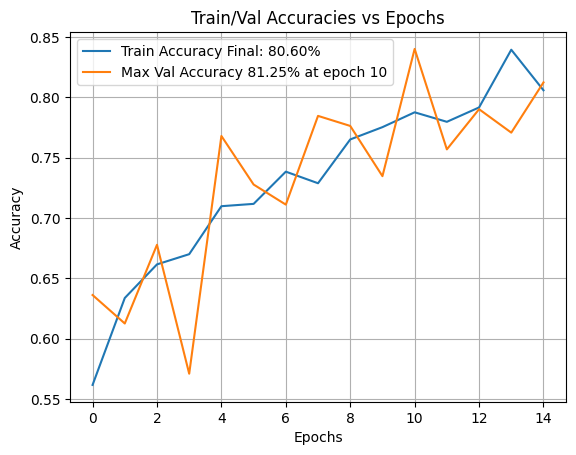

In [221]:
plt.plot([i for i in range(epochs)], train_accuracy_pep, label=f'Train Accuracy Final: {train_accuracy_pep[-1]*100:.2f}%')
plt.plot([i for i in range(epochs)], val_accuracy_pep, label=f'Max Val Accuracy {val_accuracy_pep[-1]*100:.2f}% at epoch {np.array(val_accuracy_pep).argmax()}')
plt.grid(True)
plt.title('Train/Val Accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

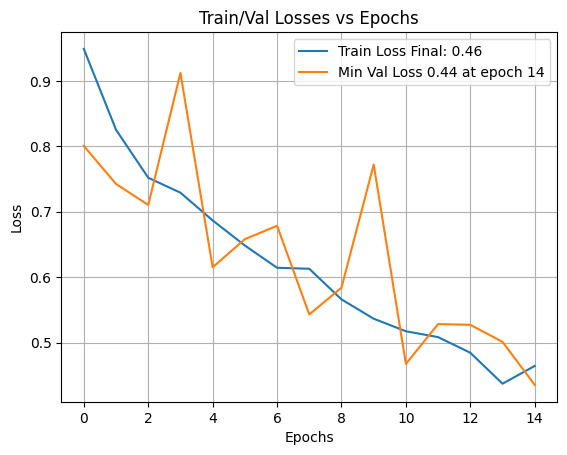

In [222]:
plt.plot([i for i in range(epochs)], train_loss_pep, label=f'Train Loss Final: {train_loss_pep[-1]:.2f}')
plt.plot([i for i in range(epochs)], val_loss_pep, label=f'Min Val Loss {val_loss_pep[-1]:.2f} at epoch {np.array(val_loss_pep).argmin()}')
plt.grid(True)
plt.title('Train/Val Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [160]:
torch.save(model.state_dict(),'saved_model_83.pth')